Matthew Virgin <br>
ECE 491 <br>
Final Project <br>
15 December 2023 <br>

Assuming you have pulled the github, you should only have to run this code. Otherwise, you'll have to make sure you have training and testing folders with 4 folders named for the 4 tumors inside each. Note that I also renamed
the "normal" folder in the "Data" folder to "no_tumor" after extracting archive.zip

In [1]:
import os

# Base directories
curr_dir = os.getcwd()
train_folder = os.path.join(curr_dir, "Training")
test_folder = os.path.join(curr_dir, "Testing")

tumor_names = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
train_dirs = []

# function that takes a parent folder name and a list of its child folder names and
# returns a list containing the proper directory names
def nameFolders(parent_name, child_name_list):
    dirs = []
    for name in child_name_list:
        full_path = os.path.join(parent_name, name)
        dirs.append(full_path)
    return dirs

# list of each train directory
train_dirs = nameFolders(train_folder, tumor_names)

# list of each test directory
test_dirs = nameFolders(test_folder, tumor_names)

In [2]:
# Put the images from the "Data" folder into the correct places in the 
# "Training" and "Testing" folders

from sklearn.model_selection import train_test_split
import shutil

no_tumors = os.path.join(train_folder, "no_tumor")
data_folder = os.path.join(curr_dir, "Data")
# Note: I renamed the "normal" folder in "Data" to "no_tumor" for consistency
data_dirs = nameFolders(data_folder, tumor_names)

# splits subchildren into train and test sets,
# moving their contents to the provided locations
def split_and_move(children):
    train_ratio = 0.6
    for i in range(len(children)):
        
        # list images in folder
        all_images = [f for f in os.listdir(children[i]) if f.endswith('.jpg')]

        train_images, test_images = train_test_split(all_images, train_size=train_ratio, random_state=42)

        for image in train_images:
            shutil.move(os.path.join(children[i], image), os.path.join(train_dirs[i], image))

        for image in test_images:
            shutil.move(os.path.join(children[i], image), os.path.join(test_dirs[i], image))

# only do this if we haven't yet
if (len(os.listdir(no_tumors)) == 0):
    split_and_move(data_dirs)

In [3]:
# function to print the length of each directory
def print_directory_lengths(directory, name):
    files = os.listdir(directory)
    print(f"{name} directory ({directory}): {len(files)} files")
    return len(files)

train_samples = 0
test_samples = 0

# print the length of each training directory
for i in range(len(train_dirs)):
    train_samples = train_samples + print_directory_lengths(train_dirs[i], "train " + tumor_names[i])
    
# print the length of each test directory
for i in range(len(test_dirs)):
    test_samples = test_samples + print_directory_lengths(test_dirs[i], "test " + tumor_names[i])
    

train glioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\glioma_tumor): 540 files
train meningioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\meningioma_tumor): 547 files
train no_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\no_tumor): 262 files
train pituitary_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Training\pituitary_tumor): 506 files
test glioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\glioma_tumor): 361 files
test meningioma_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\meningioma_tumor): 366 files
test no_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\no_tumor): 176 files
test pituitary_tumor directory (c:\Users\Matt\Desktop\School\ECE-491\Testing\pituitary_tumor): 338 files


train samples


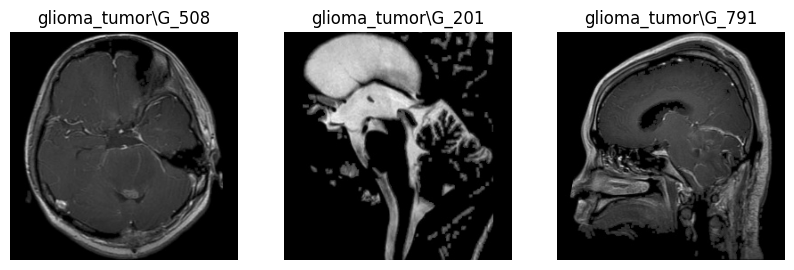

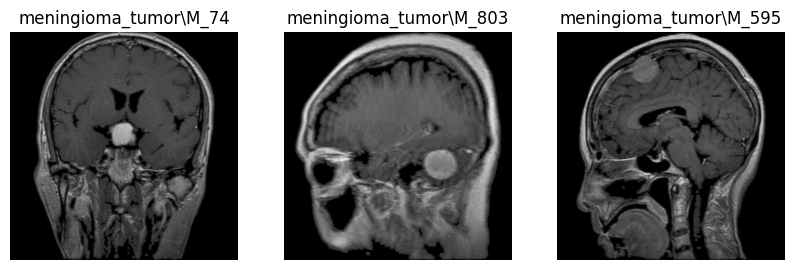

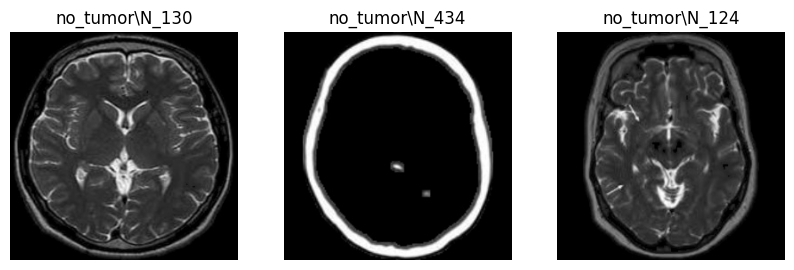

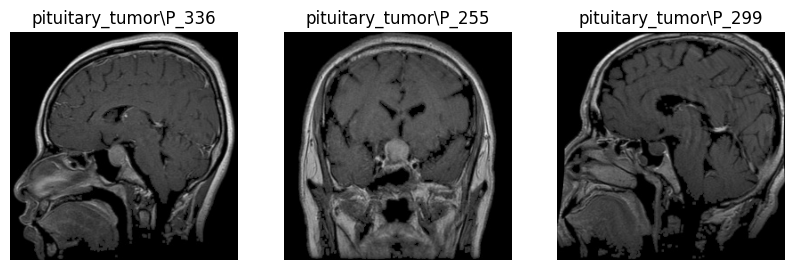

test samples


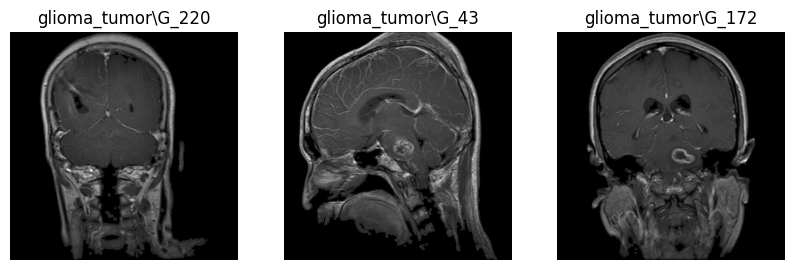

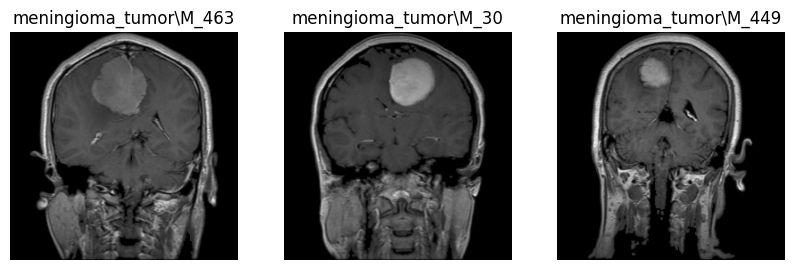

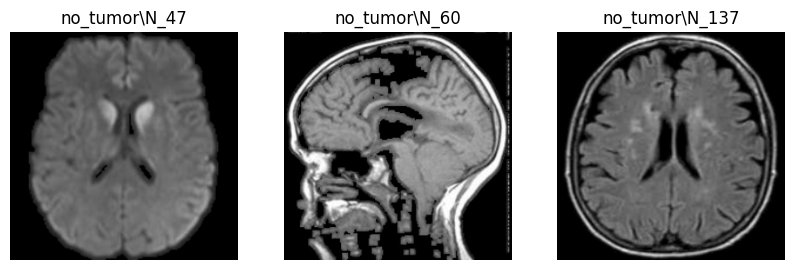

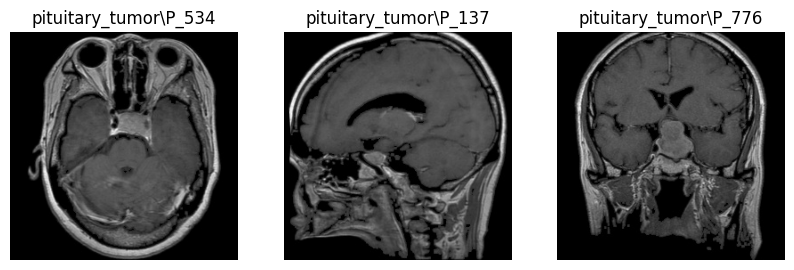

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Function to display three random images from a directory
def display_random_images(directory):
    files = os.listdir(directory)
    random_images = random.sample(files, 3)

    # Plot the random images
    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(random_images, 1):
        image_path = os.path.join(directory, image_file)

        # get the directory index for clearer labels
        second_to_last_backslash_index = image_path.rfind('\\', 0, image_path.rfind('\\'))

        plt.subplot(1, 3, i)
        img = mpimg.imread(image_path)
        plt.imshow(img)

        # title of each image includes tumor type and image name, cut off .jpg
        plt.title(f"{image_path[second_to_last_backslash_index+1:-4]}")

        plt.axis("off")

    plt.show()

# Display train samples
print("train samples")
for i in range(len(train_dirs)):
    display_random_images(train_dirs[i])

# Display test samples
print("test samples")
for i in range(len(test_dirs)):
    display_random_images(test_dirs[i])

Building the model:

In [5]:
import numpy as np
import tensorflow as tf
import math
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import LearningRateScheduler

img_size = 256 
num_classes = 4
BATCH_SIZE = 20 

pre_model = tf.keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape = (img_size, img_size, 3)   # we fabricate the two extra channels
)

# freeze model
pre_model.trainable = False

# build top layers
# x = pre_model(pre_model.input, training = False)    # inference mode
x = pre_model.output
x = layers.GlobalAveragePooling2D()(x)
# x = layers.BatchNormalization()(x)    # TODO del
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate)(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

# Configure and compile the model
model = Model(inputs = pre_model.input, outputs = outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [6]:
## compile and train model

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['acc'])

## prepare train and test generators
# train gen has augmentations like rotations and flips
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
        train_folder, # This is the source directory for training images
        batch_size= BATCH_SIZE,
        shuffle = False,
        color_mode="rgb",       # force 3 channels for use w efficientnet
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        test_folder,
        batch_size= BATCH_SIZE,
        shuffle = False,
	color_mode="rgb",
        class_mode='categorical')

## callbacks
# model checkpoint
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', mode='min', save_best_only=True)

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',  # Monitor the validation loss
                                        patience=12,          # Number of epochs with no improvement after which training will be stopped
				        restore_best_weights=True)      # Restore best weights from that period

# learning rate scheduler       
def scheduler(epoch, lr):
	initial_lrate = 0.001
	drop = 0.1
	epochs_drop = 10
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lr_schedule = LearningRateScheduler(scheduler)

history = model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_samples / float(BATCH_SIZE))),
      epochs=50,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(test_samples / float(BATCH_SIZE))),
      callbacks = [cp, es, lr_schedule],
      verbose=1)

Found 1855 images belonging to 4 classes.
Found 1241 images belonging to 4 classes.
Epoch 1/50
93/93 [==============================] - 31s 230ms/step - loss: 1.3362 - acc: 0.3617 - val_loss: 0.9874 - val_acc: 0.6221 - lr: 0.0010
Epoch 2/50
93/93 [==============================] - 19s 209ms/step - loss: 1.0565 - acc: 0.5272 - val_loss: 0.7237 - val_acc: 0.7244 - lr: 0.0010
Epoch 3/50
93/93 [==============================] - 20s 209ms/step - loss: 0.8957 - acc: 0.6329 - val_loss: 0.6806 - val_acc: 0.7115 - lr: 0.0010
Epoch 4/50
93/93 [==============================] - 19s 203ms/step - loss: 0.7695 - acc: 0.6782 - val_loss: 0.6086 - val_acc: 0.7494 - lr: 0.0010
Epoch 5/50
93/93 [==============================] - 18s 196ms/step - loss: 0.7820 - acc: 0.6668 - val_loss: 0.6582 - val_acc: 0.7180 - lr: 0.0010
Epoch 6/50
93/93 [==============================] - 18s 197ms/step - loss: 0.7317 - acc: 0.7035 - val_loss: 0.7142 - val_acc: 0.7091 - lr: 0.0010
Epoch 7/50
93/93 [======================

Analysis

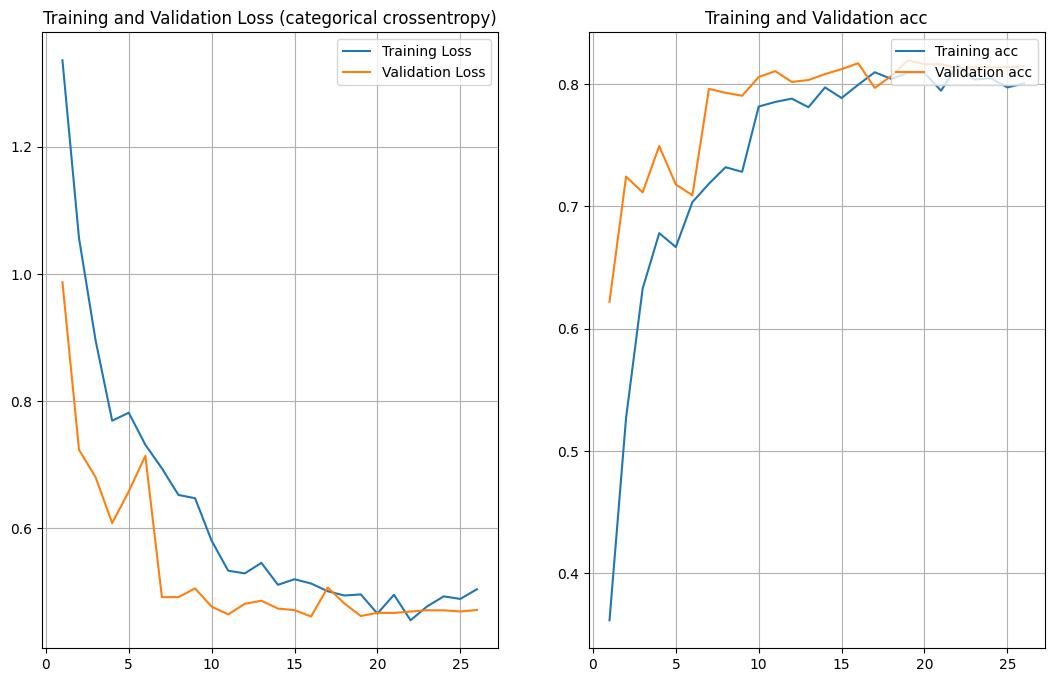

In [7]:
def plot_history(history, SKIP):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range[SKIP:], loss[SKIP:], label='Training Loss')
    plt.plot(epochs_range[SKIP:], val_loss[SKIP:], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (categorical crossentropy)')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range[SKIP:], acc[SKIP:], label='Training acc')
    plt.plot(epochs_range[SKIP:], val_acc[SKIP:], label='Validation acc')
    plt.legend(loc='upper right')
    plt.title('Training and Validation acc')

    plt.grid()
    plt.show()

plot_history(history, 0)

Fine-tuning

In [8]:
# Unfreeze the base model and train end to end

ft_model = model

# inference mode on, no need to single out BatchNorm layers
# pre_model.trainable = True
for layer in ft_model.layers:  # TODO remove if above works
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

ft_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
ft_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),       
              metrics=['acc'])

def ft_scheduler(epoch, lr):
	initial_lrate = 1e-5
	drop = 0.1
	epochs_drop = 10
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

ft_lr_schedule = LearningRateScheduler(ft_scheduler)

ft_history = ft_model.fit(
      train_generator,
      steps_per_epoch=int(np.ceil(train_samples / float(BATCH_SIZE))),
      epochs=35,
      validation_data=validation_generator,
      validation_steps=int(np.ceil(test_samples / float(BATCH_SIZE))),
      callbacks = [cp, ft_lr_schedule],  # TODO add es back  
      verbose=1)

Epoch 1/35
93/93 [==============================] - 39s 312ms/step - loss: 0.4730 - acc: 0.8092 - val_loss: 0.5501 - val_acc: 0.8082 - lr: 1.0000e-05
Epoch 2/35
93/93 [==============================] - 28s 303ms/step - loss: 0.4774 - acc: 0.8032 - val_loss: 0.3509 - val_acc: 0.8670 - lr: 1.0000e-05
Epoch 3/35
93/93 [==============================] - 27s 291ms/step - loss: 0.4320 - acc: 0.8280 - val_loss: 0.3215 - val_acc: 0.8848 - lr: 1.0000e-05
Epoch 4/35
93/93 [==============================] - 26s 281ms/step - loss: 0.3772 - acc: 0.8431 - val_loss: 0.3349 - val_acc: 0.8743 - lr: 1.0000e-05
Epoch 5/35
93/93 [==============================] - 27s 290ms/step - loss: 0.3633 - acc: 0.8609 - val_loss: 0.3140 - val_acc: 0.8759 - lr: 1.0000e-05
Epoch 6/35
93/93 [==============================] - 27s 290ms/step - loss: 0.3265 - acc: 0.8717 - val_loss: 0.2681 - val_acc: 0.8952 - lr: 1.0000e-05
Epoch 7/35
93/93 [==============================] - 27s 286ms/step - loss: 0.3131 - acc: 0.8739 - va

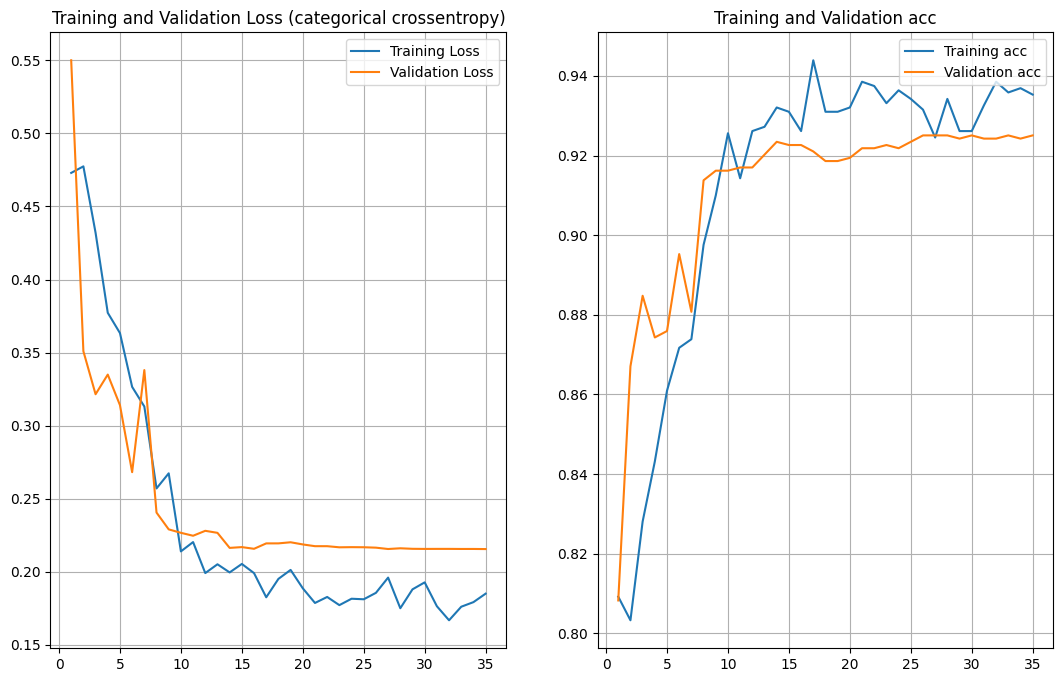

In [10]:
plot_history(ft_history, 0)

93/93 [==============================] - 16s 155ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.91      0.94       540
meningioma_tumor       0.90      0.93      0.91       547
        no_tumor       0.98      0.99      0.99       262
 pituitary_tumor       0.94      0.98      0.96       506

        accuracy                           0.95      1855
       macro avg       0.95      0.95      0.95      1855
    weighted avg       0.95      0.95      0.94      1855



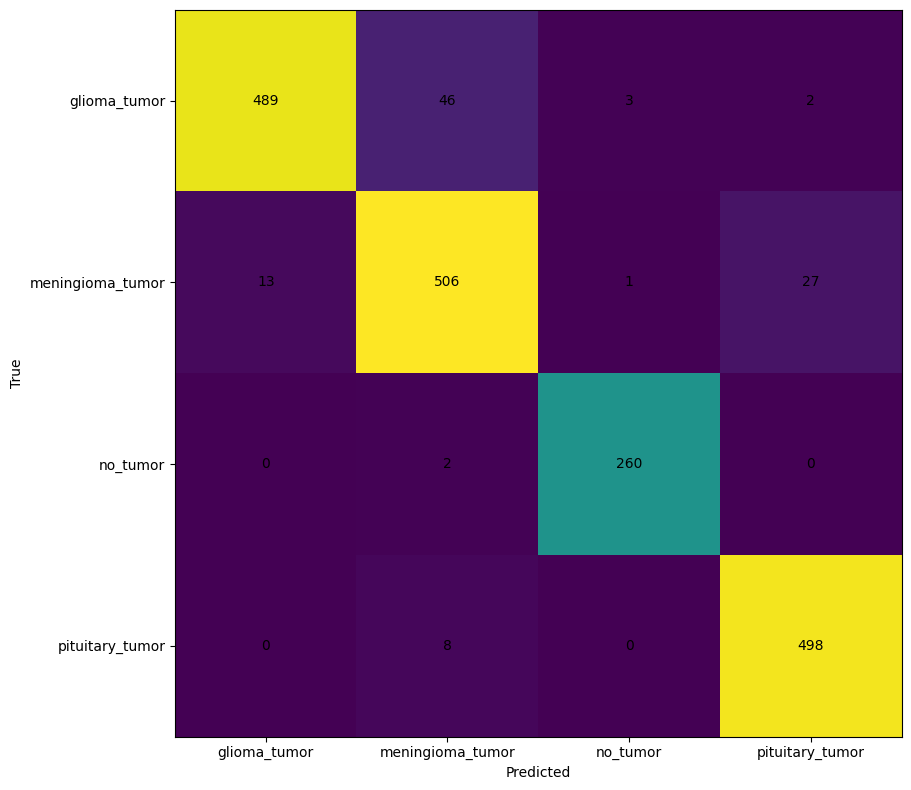

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# takes a generator and a model, makes a prediction and reports the 
# confusion matrix and classification report
def matrix_report(gen, model):
    gen.reset()
    class_labels = list(gen.class_indices.keys())

    y_truth = gen.classes
    Y_pred = model.predict(gen)  # shuffle off or results ruined
    y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(y_truth, y_pred)

    print(classification_report(y_truth, y_pred, target_names=class_labels))

    # Plot confusion matrix with class labels
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm)

    # Set ticks for class labels
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_yticks(np.arange(len(class_labels)))

    # Set tick labels
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)

    # Label axes
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Display the values in each cell
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            text = ax.text(j, i, f'{cm[i, j]}', ha='center', va='center', color='black')
    
    plt.tight_layout()

# train_generator.shuffle = False
matrix_report(train_generator, ft_model)

63/63 [==============================] - 4s 68ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.95      0.91      0.93       361
meningioma_tumor       0.89      0.90      0.89       366
        no_tumor       0.99      0.94      0.97       176
 pituitary_tumor       0.91      0.96      0.93       338

        accuracy                           0.93      1241
       macro avg       0.93      0.93      0.93      1241
    weighted avg       0.93      0.93      0.93      1241



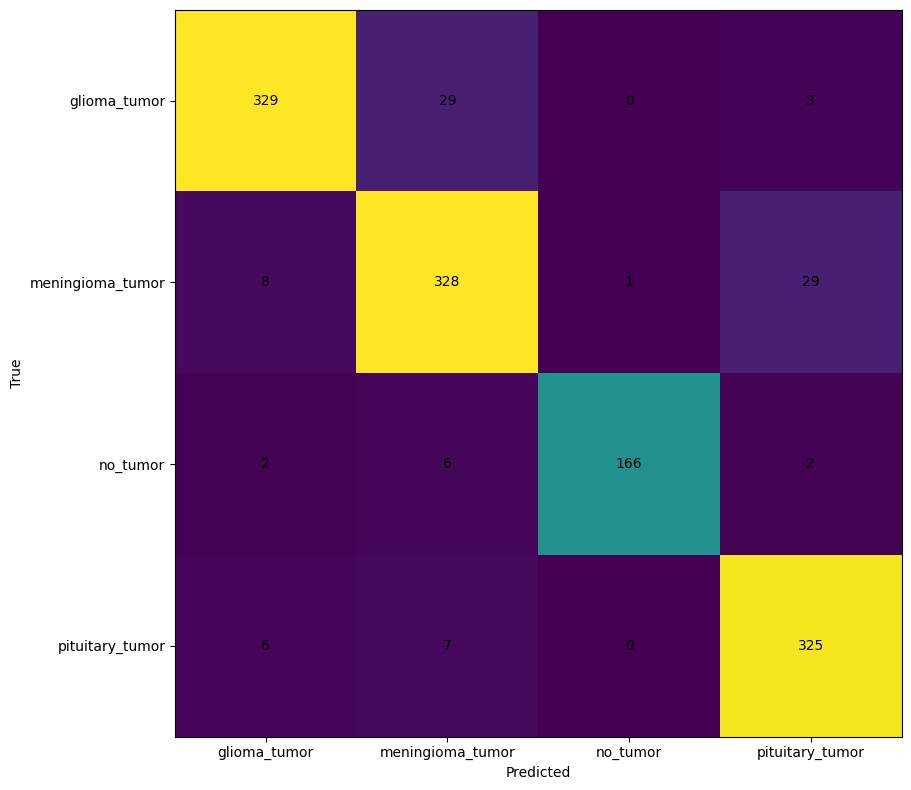

In [12]:
# validation_generator.shuffle = False
matrix_report(validation_generator, ft_model)

In [13]:
# TODO: maybe add heatmaps or graph reps of class dist above - more fluff for pres.
# TODO: top 5? top 1?
# TODO: k fold cross validation?
# TODO display the misclassified images (or like, the first 10 misclassified)